In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp

In [55]:
def solve_inner(C, q_hp, delta_T_i, delta_T_a, q_solar, SPC_sum, DHW_sum,
                Q_DHW_estimate, q_max, delta_t):
    """Solve inner CVXPY problem for a given C and return parameters + metrics."""
    N = len(delta_T_i)
    Q_sc = np.sum(q_hp) - Q_DHW_estimate - SPC_sum + DHW_sum

    # CVXPY variables
    a = cp.Variable(pos=True)
    w_s = cp.Variable(nonneg=True)
    #w_w = cp.Variable(nonneg=True)
    w = cp.Variable()
    e = cp.Variable()
    z = cp.Variable(N, nonneg=True)
    u = cp.Variable(N)
    q_hat = cp.Variable(N)

    # Expression
    expr = (delta_T_a * a * delta_t + q_hat + w_s * q_solar + w * np.ones(N) *
            delta_t)

    # Constraints
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == expr / C,
        q_hat >= 0,
        q_hat <= q_hp + z,
        q_hat <= q_max,
        a >= 1 / 25
    ]

    # Objective weights
    phi_e = 0.1
    phi_z = 0.001
    phi_u = 2000
    objective = cp.Minimize(
        phi_e * e ** 2  +
        phi_z * cp.norm2(z)  +
        phi_u * cp.norm2(u)  +
        phi_z * cp.maximum(0, -(q_hat + z)).sum() 
    )

    prob = cp.Problem(objective, constraints)
    _ = prob.solve(solver=cp.GUROBI, verbose=False)

    # Extract values
    R_a = 1 / a.value
    ws_val = w_s.value
    #ww_val = w_w.value
    w_val = w.value
    q_hat_val = q_hat.value

    # RMSE for dTi (u)
    rmse_dTi = np.sqrt(np.mean(u.value ** 2))

    # RMSE for q_hat vs q_hp
    rmse_q = np.sqrt(np.mean((q_hat.value - q_hp * delta_t) ** 2))

    return R_a, ws_val, w_val, rmse_q, rmse_dTi, q_hat_val, Q_sc

In [56]:
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

,Property_ID,Timestamp,half-hour,Boiler_Energy_Output,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,...,Postcode,Time,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed
0,EOH0279,2020-10-26 00:00:00,00:00:00,NaN,0.000,0.000,0.008,9.38,23.14,23.35,...,EH22,00:00:00,8.90,6.10,79.75,5.6,0.154,0.0,0.0,19.30
1,EOH1703,2020-10-26 00:00:00,00:00:00,NaN,0.013,0.242,0.078,7.08,25.04,24.04,...,NE15,00:00:00,7.00,4.30,81.71,4.1,0.170,0.0,0.0,14.30
2,EOH1703,2020-10-26 00:30:00,00:30:00,NaN,0.029,0.622,0.212,6.83,25.43,24.23,...,NE15,00:30:00,6.95,4.05,81.93,4.1,0.085,0.0,0.0,15.85
3,EOH0279,2020-10-26 00:30:00,00:30:00,NaN,0.000,0.000,0.019,9.33,22.54,22.80,...,EH22,00:30:00,8.85,6.30,79.94,5.6,0.077,0.0,0.0,17.00
4,EOH0279,2020-10-26 01:00:00,01:00:00,NaN,0.000,2.730,0.967,9.21,35.27,30.93,...,EH22,01:00:00,8.80,6.50,80.13,5.6,0.000,0.0,0.0,14.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505054,EOH3154,2023-09-29 00:00:00,00:00:00,NaN,0.000,44801.768,14989.282,12.44,18.87,50.46,...,EH15,00:00:00,12.80,12.80,90.62,11.3,0.333,0.0,0.0,16.00
505055,EOH1637,2023-09-29 00:00:00,00:00:00,NaN,203.311,43996.381,13830.005,12.17,16.70,16.53,...,PH7,00:00:00,13.20,13.20,86.43,11.0,0.004,0.0,0.0,17.00
505056,EOH2329,2023-09-29 00:00:00,00:00:00,NaN,31.139,14128.100,5775.602,12.44,24.80,26.31,...,EH4,00:00:00,12.90,12.90,90.75,11.4,0.378,0.0,0.0,15.00
505057,EOH2675,2023-09-29 00:00:00,00:00:00,NaN,212.928,59675.471,19247.887,12.44,14.82,14.85,...,EH9,00:00:00,13.00,13.00,93.04,11.9,0.024,0.0,0.0,24.30


In [57]:
unique_ids = df_train_detached["Property_ID"].unique()
id_use = unique_ids[0]
df_house = pd.read_csv('training_data/home_characteristics.csv')

# List of columns to check for missingness
cols = [
    "Bedrooms", "Floor_Height", "Habitable_Rooms", "House_Age",
    "House_Form", "No_Storeys", "No_Underfloor",
    "Total_Floor_Area", "Wall_Type", "MCS_DHWAnnual","HP_Size_kW"
]

# calculate min capacity in home 
cp_air = 1.005  #kJ/kgK
rho_air = 1.225  # kg/m^3
kj_to_kWh = 1/3600
df_house["Volume"] = df_house["Total_Floor_Area"] * df_house["Floor_Height"]
df_house["Min Capacity"] = df_house["Volume"] * cp_air * rho_air * kj_to_kWh

df_home_values = df_house[df_house["Property_ID"].isin(unique_ids)]

summary = df_home_values[["Property_ID", "Min Capacity"]].drop_duplicates()
print(summary)

home_dict = df_home_values.set_index("Property_ID").to_dict(orient="index")


     Property_ID  Min Capacity
76       EOH3196      0.086941
318      EOH0413      0.094570
585      EOH2329      0.099645
736      EOH1637      0.088733
1149     EOH3154      0.116411
1156     EOH2675      0.124696
1569     EOH1485      0.115696
1692     EOH0546      0.088239
2066     EOH0279      0.138493
2381     EOH1703      0.074688


In [58]:
trained_params = pd.DataFrame(index=["Floor Area", "No_Storeys", "Wall_Type",
                                     "C", "R_a", "w_s", "w_w", "w",
                                     "Q_hat", "Q_sc", "rmse_dTi",
                                     "rmse_q_hp"])

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
df_single = df_single.set_index('Timestamp')

#time range for indexing only
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:59")
df_index = df_single[df_single.index >= t_start]
df_index = df_index[df_index.index <= t_end]
df_index = df_index[
    (df_index.index <= t_mid_end) | (df_index.index >= t_mid_start)]

# Create time index for q_hat arrays
time_index = df_index.index[:-1]
df_q_id = pd.DataFrame(index=time_index)


# ---- initialize and clean data ---------
wall = home_dict[id_use]["Wall_Type"]
storeys = home_dict[id_use]["No_Storeys"]
floor_area = home_dict[id_use]["Total_Floor_Area"]

df_single = df_train_detached[
    df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single[
    "Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single[
    "Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] -
     df_single["Internal_Air_Temperature"])

# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(
    method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy()
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

#print(f"\nNumber of rows dropped after handling NA values (missing for >
# 2 hours): {rows_dropped_after_interpolation}")

# -----EXTRACT SUMMER DATA -------# 
df_heating_single = df_single_processed.copy()
#df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]

# Time range
t_start = pd.to_datetime("2022-6-01 00:00:00")
t_end = pd.to_datetime("2022-08-30 23:59:00")
df_DHW = df_heating_single[
    (df_heating_single.index >= t_start) & (
                df_heating_single.index <= t_end)
    ].copy()

df_DHW.drop("Property_ID", axis=1, inplace=True)
df_DHW.drop("half-hour", axis=1, inplace=True)
df_DHW.drop("Date", axis=1, inplace=True)
df_DHW.drop("has_data", axis=1, inplace=True)

i = 24

df_numeric = df_DHW.select_dtypes(include='number')

# Resample and compute mean
df_resampled = df_numeric.resample(f'{i}h').mean()

df_DHW_only = df_resampled[
    df_resampled["Heat_Pump_Energy_Output_Diff"] <= 0.15]

DHW_sum = []
DHW_sum = df_DHW_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

df_spc_only = df_resampled[
    df_resampled["Heat_Pump_Energy_Output_Diff"] > 0.15]
SPC_sum = df_spc_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

# ------ Prepare Training Data ----------
df_heating_single = df_single_processed.copy()

#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:59")
df_heating_annual = df_heating_single[df_heating_single.index >= t_start]
df_heating_annual = df_heating_annual[df_heating_annual.index <= t_end]
df_heating_annual = df_heating_annual[
    (df_heating_annual.index <= t_mid_end) | (df_heating_annual
                                              .index >= t_mid_start)]

t_step = 30  # minutes
delta_t = t_step / 60

T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy())
T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy())
delta_T_a = (
    df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
    .reset_index(drop=True).to_numpy())
delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t)
q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy())
q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy())
v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy())

N = len(delta_T_i)

Q_DHW_estimate = home_dict[id_use]["MCS_DHWAnnual"]
q_max = home_dict[id_use]["HP_Size_kW"]

# Create time index for in the loop q_hat arrays
time_index = df_heating_annual.index[:-1]
df_q_results = pd.DataFrame(index=time_index)

# Grid search and store results
C_values = np.arange(1.5, 6, 0.1)
results = []

for C in C_values:
    R_a, ws, w, rmse_q, rmse_dTi, q_hat_val, Q_sc = solve_inner(C, q_hp,
                                                                delta_T_i,
                                                                delta_T_a,
                                                                q_solar,
                                                                SPC_sum,
                                                                DHW_sum,
                                                                Q_DHW_estimate,
                                                                q_max,
                                                                delta_t)
    
    #Save each q_hat under C value for iteration
    df_q_results[f"C_{C:.1f}"] = q_hat_val

    results.append({
        "C": C,
        "R_a": R_a,
        "w_s": ws,
        #"w_w": ww, #wind doesn't do much on average
        "w": w,
        "Q_hat": np.sum(q_hat_val),
        "Q_sc": Q_sc,
        "rmse_q": rmse_q,
        "rmse_dTi": rmse_dTi
    })
    #print(f"C={C:.2f} | R_a={R_a:.4f} | w_s={ws:.4f} | w={w:.4f} | "
    #      f"rmse_q={rmse_q:.4f} | rmse_dTi={rmse_dTi:.4f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results.sort_values(by=["rmse_dTi","rmse_q"], ascending=True, inplace=True)

top_result = df_results.iloc[0]
print(top_result)

df_q_id[id_use] = df_q_results[f"C_{top_result["C"]:.1f}"]

'''
print("Optimal C_a:", top_result["C"])
print("Optimal R_a:", top_result["R_a"])
print("w_s (solar gain):", top_result["w_s"])
print("w_w (wind effect):", 'NA')
print("w (bias):", top_result["w"])
print("Q_hat total:", top_result["Q_hat"])
print("Q_sc:", top_result["Q_sc"])
print("RMSE dTi:", top_result["rmse_dTi"])
print("RMSE q_hat:", top_result["rmse_q"])
'''
trained_params[id_use] = [floor_area, storeys, wall, top_result["C"],
                          top_result["R_a"], top_result["w_s"], "NA",
                          top_result["w"], top_result["Q_hat"],
                          top_result["Q_sc"], top_result["rmse_dTi"],
                          top_result["rmse_q"]]
    
    
    

C                            1.5
R_a                    12.003786
w_s                          0.0
w           -0.11900357980311509
Q_hat                5541.175559
Q_sc                    5521.047
rmse_q                   0.31099
rmse_dTi                0.048936
Name: 0, dtype: object


In [59]:
trained_params

,EOH0279
Floor Area,172.33
No_Storeys,2.0
Wall_Type,Cavity_Insulated
C,1.5
R_a,12.003786
w_s,0.0
w_w,NA
w,-0.11900357980311509
Q_hat,5541.175559
Q_sc,5521.047


RMSE of q_hp: 0.888081976922972


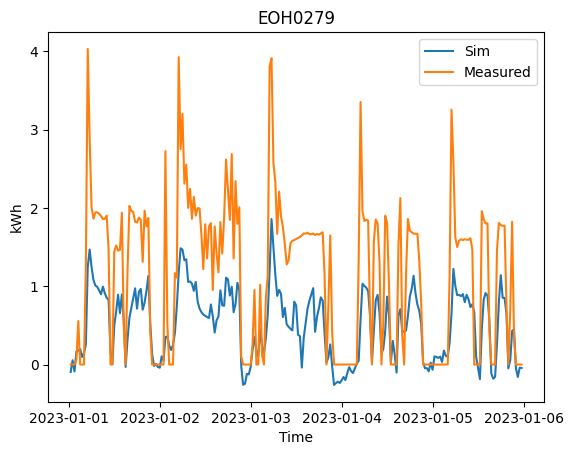

In [60]:
# ------- Look at heat supply performance in validation data ------

df_id = trained_params[id_use].copy()
C = df_id.C
R_a = df_id.R_a
w_s= df_id.w_s
w = df_id.w


df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] - 
     df_single["Internal_Air_Temperature"])
     


# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

# 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy() 
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

#print(f"\nNumber of rows dropped after handling NA values (missing for >
# 2 hours): {rows_dropped_after_interpolation}")

# -----EXTRACT SUMMER DATA -------# 
df_heating_single = df_single_processed.copy()

t_start = pd.to_datetime("2023 01 01 00:00:00")
t_end = pd.to_datetime("2023 01 05 23:59:00")
df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]



T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 



q_hat_sim = (delta_T_i_val * C -  delta_T_a_val / R_a * delta_t  - w_s *  
        q_solar_val  - w * np.ones(len(T_a_val), )* delta_t )

e_q = q_hat_sim - q_hp_val
rmse_q_val = np.sqrt(np.mean(e_q**2))
print(f"RMSE of q_hp: {rmse_q_val}")

plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.title(f"{id_use}")
plt.show()

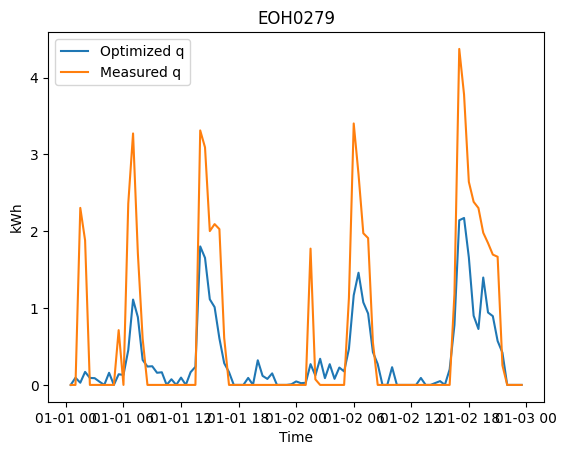

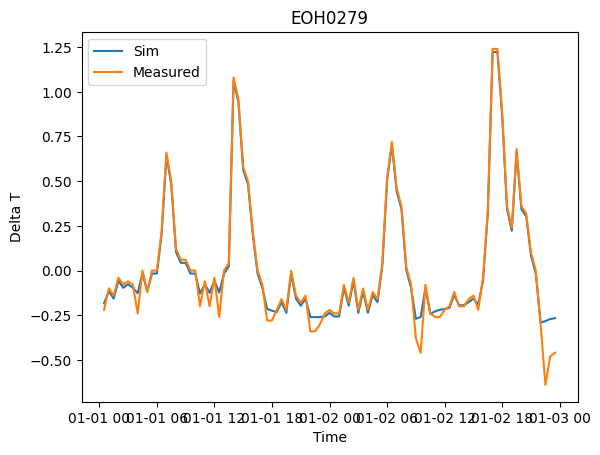

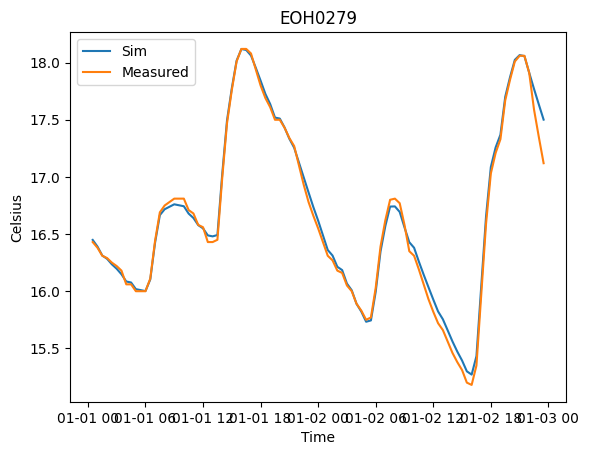

In [61]:
# -----Look at temperature tracking performance in the training --------------

df_id = trained_params[id_use].copy()
C = df_id.C
R_a = df_id.R_a
w_s= df_id.w_s
w = df_id.w

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] - 
     df_single["Internal_Air_Temperature"])
     


# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

# 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy() 
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

#print(f"\nNumber of rows dropped after handling NA values (missing for >
# 2 hours): {rows_dropped_after_interpolation}")

# -----EXTRACT SUMMER DATA -------# 
df_heating_single = df_single_processed.copy()

# Validate results
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_end = pd.to_datetime("2022 01 02 23:59:00")
df_q_id_use = df_q_id[(df_q_id.index>=t_start) & (df_q_id.index<=t_end)]
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]



T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_opt = df_q_id_use[id_use].iloc[:-1].reset_index(drop=True).to_numpy()
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 


delta_T_i_sim = (delta_T_a_val / R_a *delta_t + q_opt + w_s* q_solar_val + w
                 * np
                 .ones(len(T_a_val), )* delta_t) / C

T_i_sim = np.zeros_like(T_i_val)
T_i_prev = T_i_val[0]
for i in range(len(delta_T_i_sim)):
    T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
    T_i_prev = T_i_sim[i]


plt.plot(df_heating_val.index[1:],q_opt, label = "Optimized q")
plt.plot(df_heating_val.index[1:],q_hp_val, label = "Measured q")

plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.title(f"{id_use}")
plt.show()

plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Delta T")
plt.title(f"{id_use}")
plt.show()

plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
         .iloc[1:].reset_index
       (drop=True).to_numpy(), label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Celsius")
plt.title(f"{id_use}")
plt.show()